,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)

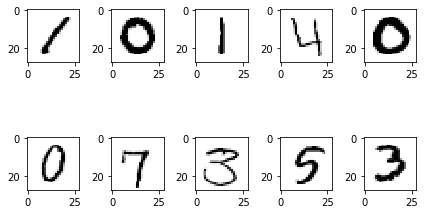

In [5]:
# MNIST 구현

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

# Raw Data Loading
df = pd.read_csv('./data/digit/train.csv')
display(df, df.shape)

# 데이터의 명세를 잘 파악해야 함.
# 각 픽셀의 값은 0 ~ 255 사이의 값을 가질 수 있음.
# 이 값이 크면 클 수록 어두운 색상임.
# 어떻게 알 수 있음? kaggle Data Description

# 이상치와 결측치가 없음

# 이미지 확인
img_data = df.drop('label', axis=1, inplace=False).values # 2차원 numps로 변환

fig = plt.figure()
fig_arr = []  # 10개의 subplot을 만들고 그 각각의 subplot을 list에 저장

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='Greys', 
                      interpolation='nearest')
plt.tight_layout()
plt.show()

# 흑백 이미지로 바꿔서도 할 수 있음.
# 흑백으로 처리해서 하는것이 효율적이다.

# 데이터 분할
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False),
                 df['label'], test_size=0.3, random_state=0)

# 정규화 (feature가 0~255 까지 이기 때문에 정규화 필요)
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

# placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit) # softmax activation function

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# parameter
num_of_epoch = 1000
batch_size = 100 # 한번에 읽어들일 학습할 데이터의 사이즈

# 학습용 함수
# cross validation을 하기 위해
def run_train(sess, train_x, train_t):
    print('### 학습 시작')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train,loss], feed_dict={X:batch_x,
                                                            T:batch_t})
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    print('###학습 종료###')
    
# Accuracy 측정
predict = tf.argmax(H,1) # axis 열방향으로 비교 1
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

In [6]:
# K-Fold Cross Validation
cv = 5  # Fold의 수
results = [] # 각 Fold당 학습과 성능평가가 진행되는데 이때 계산된 성능평가 값을 저장

# 훈련set과 검증set으로 나누기
kf = KFold(n_splits=cv, shuffle=True)

for training_idx, validation_idx in kf.split(x_data_train_norm):
    training_x = x_data_train_norm[training_idx] 
    training_t = t_data_train_onehot[training_idx]
    
    val_x = x_data_train_norm[validation_idx]
    val_t = t_data_train_onehot[validation_idx]
    
    # 학습
    run_train(sess,training_x,training_t)
    results.append(sess.run(accuracy, feed_dict={X:val_x, T:val_t}))
    
print('측정한 각각의 결과값 : {}'.format(results))
print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))

### 학습 시작
Loss: 1.9497268199920654
Loss: 0.20953674614429474
Loss: 0.16432689130306244
Loss: 0.14341400563716888
Loss: 0.1312403529882431
Loss: 0.12324666976928711
Loss: 0.11761331558227539
Loss: 0.11341657489538193
Loss: 0.11012786626815796
Loss: 0.10743162035942078
###학습 종료###
### 학습 시작
Loss: 2.478250741958618
Loss: 0.23764991760253906
Loss: 0.1871141940355301
Loss: 0.16656982898712158
Loss: 0.15700161457061768
Loss: 0.15123291313648224
Loss: 0.14714626967906952
Loss: 0.14401841163635254
Loss: 0.14150165021419525
Loss: 0.13938194513320923
###학습 종료###
### 학습 시작
Loss: 1.9044626951217651
Loss: 0.1872226893901825
Loss: 0.1546766608953476
Loss: 0.13909298181533813
Loss: 0.1297958791255951
Loss: 0.1237330436706543
Loss: 0.11955387145280838
Loss: 0.11653917282819748
Loss: 0.11426984518766403
Loss: 0.11248742789030075
###학습 종료###
### 학습 시작
Loss: 2.431135654449463
Loss: 0.21728545427322388
Loss: 0.19116386771202087
Loss: 0.17515066266059875
Loss: 0.16432525217533112
Loss: 0.15682798624038696


In [7]:
# Testing
run_train(sess,x_data_train_norm,t_data_train_onehot)
final_accuracy = sess.run(accuracy, feed_dict={X:x_data_test_norm,
                                               T:t_data_test_onehot})
print('우리 Model의 최종 정확도는 : {}'.format(final_accuracy))

# 만약 Precision, Recall, F1, Accuracy를 각각 구하고 싶으면?
target_names = ['num0', 'num1', 'num2', 'num3', 'num4', 'num5',
                'num6', 'num7', 'num8', 'num9']


print(classification_report(t_data_test,
                      sess.run(predict, feed_dict={X:x_data_test_norm}),
                      target_names = target_names)) # 인자 순서 : 1. 정답(one-hot 안된 형태), 2.예측값

### 학습 시작
Loss: 1.7512856721878052
Loss: 0.21291346848011017
Loss: 0.17318828403949738
Loss: 0.16055148839950562
Loss: 0.15405334532260895
Loss: 0.15000413358211517
Loss: 0.14719103276729584
Loss: 0.1450308859348297
Loss: 0.1432146281003952
Loss: 0.14158335328102112
###학습 종료###
우리 Model의 최종 정확도는 : 0.9128571152687073
              precision    recall  f1-score   support

        num0       0.95      0.95      0.95      1242
        num1       0.95      0.97      0.96      1429
        num2       0.90      0.89      0.90      1276
        num3       0.90      0.89      0.90      1298
        num4       0.91      0.91      0.91      1236
        num5       0.87      0.88      0.87      1119
        num6       0.93      0.95      0.94      1243
        num7       0.95      0.92      0.93      1334
        num8       0.87      0.87      0.87      1204
        num9       0.88      0.90      0.89      1219

    accuracy                           0.91     12600
   macro avg       0.91      0.9

In [10]:
# 제출하기

# test data 불러오기
df_test = pd.read_csv('./data/digit/test.csv')
test_x_data = df_test.values.reshape(-1,784)

# 정규화
test_X_data_norm = scaler.transform(test_x_data)

# Test data
test_result = sess.run(predict, feed_dict={X: test_X_data_norm})

# submission
submission = pd.read_csv('./data/digit/sample_submission.csv')
submission['Label'] = test_result
submission.to_csv('./data/digit/submission.csv', index=False)